***Reference:***

***Raschka, Sebastian; Liu, Yuxi (Hayden); Mirjalili, Vahid. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.*** 

# ***<u>Chapter 7</u> - Combining Different Models for Ensemble Learning***

## Learning with ensembles

- The goal of **ensemble methods** is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone. Ensembles are typically recognized for yielding a good generalization performance. 

- **Majority Voting Principle:** Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes. Strictly speaking, the term “majority vote” refers to binary class settings only. However, it is easy to generalize the majority voting principle to multiclass settings, which is known as **plurality voting**.

<div>
<img src="Images/voting.png" width="400px"/>
</div>

- Using the training dataset, we start by training m different classifiers $(C_1, \cdots, C_m)$. Depending on the technique, the ensemble can be built from different classification algorithms, for example, decision trees, support vector machines, logistic regression classifiers, and so on. 

- Alternatively, we can also use the same base classification algorithm, fitting different subsets of the training dataset. One prominent example of this approach is the random forest algorithm combining different decision tree classifiers.

<div>
<img src="Images/ensemble.png" width="340px"/>
</div>

- To predict a class label via majority or plurality voting, we combine the predicted class labels of each individual classifiers, $C_j$, and select the class label, $\hat{y}$, that received the most votes:

$$\hat{y} = \text{mode}\{C_1(x), C_2(x), \cdots, C_m(x)\}$$

## Implementing a simple majority vote classifier

Our goal is to build a stronger meta-classifier that balances out the individual classifiers’ weaknesses on a particular dataset. 
In mathematical terms, we can write the weighted majority vote as follows:

$$\hat{y} = \arg \max_{i}\sum_{j=1}^{m}w_j\chi_{A}(C_l(x) = i)$$

Here, 
   - $w_j$ is a weight associated with a base classifier, $C_j$;  
   - $\hat{y}$ is the predicted class label of the ensemble; 
   - $A$ is the set of unique class labels;  
   - $\chi_{A}$ is the characteristic function or indicator function, which returns 1 if the predicted class of the *jth* classifier matches ***i*** $(C_j(x) = i)$. 
   
For equal weights, we can simplify this equation and write it as follows:

$$\hat{y} = \text{mode}\{C_1(x), C_2(x), \cdots, C_m(x)\}$$

Let's assume we have 3 base classifiers, $C_j (j \in \{1,2,3\})$ and want to predict the class label, $C_j(x) \in {0,1}$, for a given example, $x$. There prediction are as $$C_1(x) \rightarrow 0, C_2(x) \rightarrow 0, C_3(x) \rightarrow 1$$ 

In case of equal weigths for the classifier, the prediction is $$\hat{y} = \text{mode}\{0,0,1\} = 0$$

Now, let's assign weights of $0.6$ to $C_3$, and $0.2$ to $C_1$ & $C_2$:

$$\hat{y} = \arg \max_{i}\sum_{j=1}^{m}w_j\chi_{A}(C_l(x) = i)\\
          = \arg \max_{i}[0.2 \times i_0 + 0.2 \times i_0, 0.6 \times i_1] = 1$$
          
More simply the prediction made by $C_3$ has $3$ times more weight that taht of $C_1$ or $C_2$, which can be written as:

$$\hat{y} = \text{mode}\{0,0,1,1,1\} = 1$$

Below is the code for it:

In [1]:
import numpy as np

np.argmax(np.bincount([0, 0, 1], 
                      weights=[0.2, 0.2, 0.6]))

1

Using the predicted class probabilities instead of the class labels for majority voting can be useful if the classifiers in our ensemble are well calibrated. The modified version of the majority vote for predicting class labels from probabilities can be written as follows:

$$\hat{y} = \arg \max_i \sum_{j=1}^{m}w_jp_{ij}$$

***Here, $\textbf{p}_{ij}$ is the predicted prob. of the $jth$ classifier for class label $i$.***


Continuing the previous example, let classifier $C_j$ return following class probabilities for class labels $i \in \{0,1\}$ for a particular example, $x$:

$$C_1(x) \rightarrow [0.9,0.1], C_2(x) \rightarrow [0.8,0.2], C_3(x) \rightarrow [0.4,0.6]$$

Using the same weights as previously $(0.2, 0.2, and 0.6)$, the individual class probabilities  are as follows:

$$p(i_0|\textbf{x}) = 0.2 \times [0.9 + 0.8] + 0.6 \times 0.4 = 0.58$$
$$p(i_1|\textbf{x}) = 0.2 \times [0.1 + 0.2] + 0.6 \times 0.6 = 0.42$$
$$\hat{y} = \arg \max_i[p(i_0|\textbf{x}), p(i_1|\textbf{x})] = 0$$

Below is the code for that:

In [2]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex, 
               axis=0, 
               weights=[0.2, 0.2, 0.6])

print(p)
print(np.argmax(p))

[0.58 0.42]
0


### Implementing ```MajorityVoteClassifier```

In [3]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

We used the ```BaseEstimator``` and ```ClassifierMixin``` parent classes to get some base functionality for free, including the ```get_params``` and ```set_params``` methods to set and return the classifier’s parameters, as well as the score method to calculate the prediction accuracy. 


Next, we will add the ```predict``` method to predict the class label via a majority vote based on the class labels if we initialize a new ```MajorityVoteClassifier``` object with ```vote='classlabel'```. Alternatively, we will be able to initialize the ensemble classifier with ```vote='probability'``` to predict the class label based on the class membership probabilities. Furthermore, we will also add a ```predict_proba``` method to return the averaged probabilities, which is useful when computing the **receiver operating characteristic area under the curve (ROC AUC).**


Also, note that we defined our own modified version of the ```get_params``` method to use the ```_name_estimators``` function to access the parameters of individual classifiers in the ensemble.

### Using the majority voting principle to make predictions

In [4]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [5]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [6]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


## Evaluating and tuning the ensemble classifier

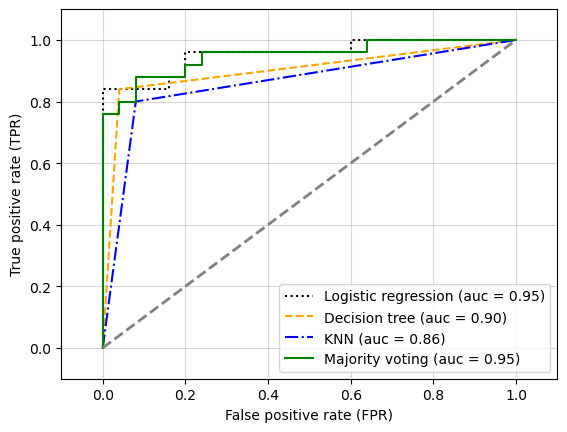

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


plt.show();

In the resulting ROC, the ensemble classifier also performs well on the test dataset (ROC AUC = 0.95). However, the logistic regression classifier performs similarly well on the same dataset, which is probably due to the high variance (in this case, the sensitivity of how we split the dataset) given the small size of the dataset.

In [8]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

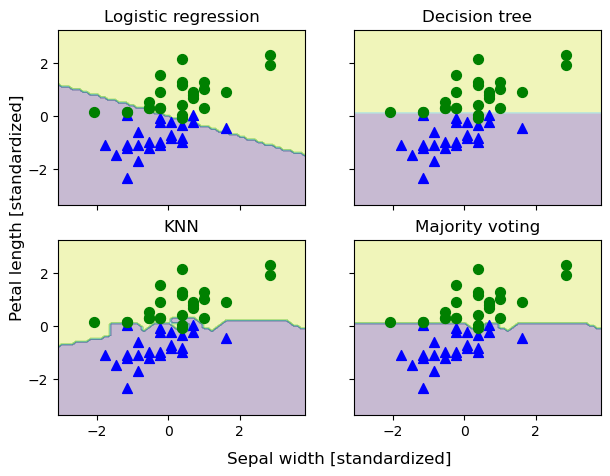

In [9]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.show();

The decision regions of the ensemble classifier seem to be a hybrid of the decision regions from the individual classifiers. At first glance, the majority vote decision boundary looks a lot like the decision of the decision tree stump, which is orthogonal to the y axis for sepal width ≥ 1. However, the nonlinearity from the k-nearest neighbor classifier is also mixed in.

In [10]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

Tuning the inverse regularization parameter, ```C```, of the logistic regression classifier and the decision tree depth via grid search.

In [11]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [12]:
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98


In [13]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [14]:
mv_clf = grid.best_estimator_

In [15]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

In [16]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.001,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=1,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])])

## Bagging - *Building an ensemble of classifiers from bootstrap samples*

- ***Bagging is an ensemble learning technique that is closely related to the ```MajorityVoteClassifier```. However, instead of using the same training dataset to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training dataset, which is why bagging is also known as bootstrap aggregating.***

<div>
<img src="Images/bagging.png" width="400px"/>
</div>


- **Bagging Example:**
<div>
<img src="Images/bagging_ex.png" width="600px"/>
</div>

- ***Random Forests are a special case of bagging where we use random feature subsets when fitting individual decision trees.***

### Applying bagging to classify examples in the Wine dataset

In [17]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values\

# Here we are using only tow features & two class labels

In [18]:
# Encoding class labels into binary format & train test split

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y = le.fit_transform(y)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,
                                                stratify=y, random_state=1)

In [19]:
# Here, using a unpruned Decision tree as a base classifier and creating 
# an ensemble of 500 decision trees fit on diff. bootstrap samples of 
# training data

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', random_state=1,
                              max_depth=None)

bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500,max_samples=1.0,
                        max_features=1.0,bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1, random_state=1)

In [20]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train,y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

Decision tree train/test accuracies 1.000/0.833


Based on the accuracy values above, the unpruned decision tree predicts all the class labels of the training examples correctly; **however, the substantially lower test accuracy indicates high variance (overfitting) of the model.**

In [21]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

Bagging train/test accuracies 1.000/0.917


Although the training accuracies of the decision tree and bagging classifier are similar on the training dataset (both 100%), we can see that the bagging classifier has a slightly better generalization performance, as estimated on the test dataset.

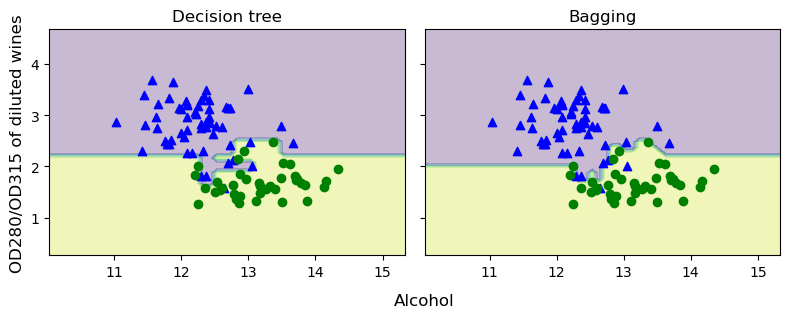

In [22]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)


plt.show();

As we can see in the above plot, the piece-wise linear decision boundary of the three-node deep decision tree looks smoother in the bagging ensemble.

### Imp. points on Bagging

- *In practice, more complex classification tasks and a dataset’s high dimensionality can easily lead to overfitting in single decision trees, and this is where the bagging algorithm can really play to its strengths.* 

- ***Finally, we must note that the bagging algorithm can be an effective approach to reducing the variance of a model.*** 

- ***However, bagging is ineffective in reducing model bias, i.e., models that are too simple to capture the trends in the data well. This is why we want to <u>perform bagging on an ensemble of classifiers with low bias, for example, unpruned decision trees.</u>***

## Leveraging weak learners via *adaptive boosting(AdaBoost)*

### Boosting

- In boosting, the ensemble consists of very simple base classifiers, also often referred to as **weak learners**, which often only have a slight performance advantage over random guessing—***a typical example of a weak learner is a decision tree stump***. 

- **The key concept behind boosting is to focus on training examples that are hard to classify, i.e., to let the weak learners subsequently learn from misclassified training examples to improve the performance of the ensemble.**

### How adaptive boosting works

- **In contrast to bagging, the initial formulation of the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement.**

- *The original boosting procedure is:*

   1. Draw a random subset(sample) of training subset, $d_1$, without replacement from the training dataset, $D$, to train a weak learner, $C_1$.
   
   2. Draw a second random training subset, $d_2$, without replacement from the training dataset and add 50% of the examples that were previously misclassified to train a weak learner, $C_2$.
   
   3. Find the training examples, $d_3$, in the training dataset, $D$, which $C_1$ and $C_2$ disagree upon, to train a third weak learner, $C_3$.
   
   4. Combine the weak learners $C_1$, $C_2$, $C_3$ via majority voting.
   

- **Boosting can lead to a decrease in bias as well as variance compared to bagging models.** 

- **In practice, however, boosting algorithms such as AdaBoost are also known for their high variance, i.e., the tendency to overfit the training data.**

------------------------------------------------------------

### AdaBoost illustration step by step

**In contrast to the original boosting procedure described, AdaBoost uses the complete training dataset to train the weak learners, where the training examples are reweighted in each iteration to build a strong classifier that learns from the mistakes of the previous weak learners in the ensemble.**


<div>
<img src="Images/adaBoost.png" width="400px"/>
</div>


We will start with subfigure 1, which represents a training dataset for binary classification where all training examples are assigned equal weights. Based on this training dataset, we train a decision stump (shown as a dashed line) that tries to classify the examples of the two classes (triangles and circles), as well as possibly minimizing the loss function (or the impurity score in the special case of decision tree ensembles). 


For the next round (subfigure 2), we assign a larger weight to the two previously misclassified examples (circles). Furthermore, we lower the weight of the correctly classified examples. The next decision stump will now be more focused on the training examples that have the largest weights—the training examples that are supposedly hard to classify. 

The weak learner shown in subfigure 2 misclassifies three different examples from the circle class, which are then assigned a larger weight, as shown in subfigure 3. 


Assuming that our AdaBoost ensemble only consists of three rounds of boosting, we then combine the three weak learners trained on different reweighted training subsets by a weighted majority vote, as shown in subfigure 4.

### AdaBoost Pseudo Code

For clarity, we will denote element-wise multiplication by the cross symbol (×) and the dot-product between two vectors by a dot symbol (⋅):


1. Set the weight vector, **w**, to uniform weights, where $\sum_iw_i = 1$.
   
2. For $j$ in $m$ boosting rounds,:

   a. Train a weighted weak learner: $C_j = train(\textbf{X, y, w})$.
     
   b. Predict the class labels: $\hat{y} = predict(C_j, X)$.
   
   c. Compute the weighted error rate: $\epsilon = \textbf{w} \cdot (\hat{y} \neq y)$.
   
   d. Compute the coefficient: $\alpha_j = 0.5\frac{1 - \epsilon}{\epsilon}$.
   
   e. Update the weights: $w := w \times exp(-\alpha_j \times \hat{y} \times y)$.
   
   f. Normalize the weights to sum to 1: $w := \frac{w}{\sum_iw_i}$.
   
3. Compute the final prediction: $\hat{y} = \left(\sum_{j=1}^{m}\left(\alpha_j \times predict(C_j, X)\right) > 0\right)$.


***Note that the expression $(\hat{y}\neq y)$ in step 2c refers to a binary vector consisting of $1s$ and $0s$, where a $1$ is assigned if the prediction is incorrect and $0$ is assigned otherwise.***



<div>
<img src="Images/adaBoost_ex.png" width="400px"/>
</div>

A simple adaboost example based on above pseudo code for a 1D-dataset assuming splitting criterion $x \leq 3.0$.

In [23]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [24]:
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [25]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [26]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [27]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [28]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [29]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


### AdaBoost in scikit-learn

In [30]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1,
                             random_state=1)

ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500,
                         learning_rate=0.1, random_state=1)

In [31]:
tree = tree.fit(X_train, y_train)

y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')


ada = ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 

print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


As you can see, the decision tree stump seems to underfit the training data in contrast to the unpruned decision tree that we saw in the previous section.


Here, you can see that the AdaBoost model predicts all class labels of the training dataset correctly and also shows a slightly improved test dataset performance compared to the decision tree stump. ***However, you can also see that we introduced additional variance with our attempt to reduce the model bias—a greater gap between training and test performance.***

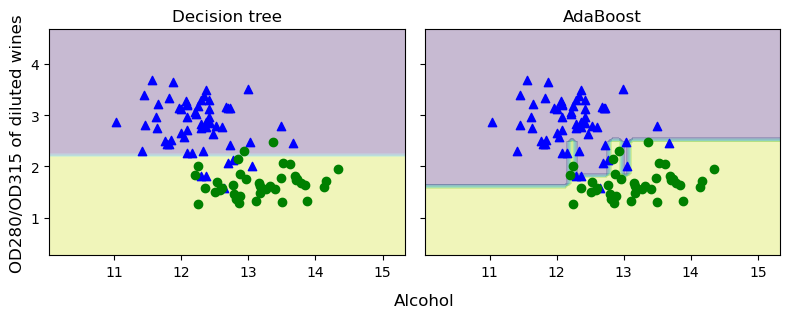

In [32]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)


plt.show();

By looking at the decision regions, you can see that the decision boundary of the AdaBoost model is substantially more complex than the decision boundary of the decision stump. In addition, note that the AdaBoost model separates the feature space very similarly to the bagging classifier that we trained in the previous section.


*As concluding remarks about ensemble techniques, it is worth noting that ensemble learning increases the computational complexity compared to individual classifiers. In practice, we need to think carefully about whether we want to pay the price of increased computational costs for an often relatively modest improvement in predictive performance.*

## *Gradient boosting* - training an ensemble based on loss gradients

### Comparing AdaBoost with gradient boosting

- Fundamentally, gradient boosting is very similar to AdaBoost. 


- AdaBoost trains decision tree stumps based on errors of the previous decision tree stump. In particular, the errors are used to compute sample weights in each round as well as for computing a classifier weight for each decision tree stump when combining the individual stumps into an ensemble. We stop training once a maximum number of iterations (decision tree stumps) is reached. 


- Like AdaBoost, gradient boosting fits decision trees in an iterative fashion using prediction errors. However, gradient boosting trees are usually deeper than decision tree stumps and have typically a maximum depth of 3 to 6 (or a maximum number of 8 to 64 leaf nodes). 

-  Also, in contrast to AdaBoost, gradient boosting does not use the prediction errors for assigning sample weights; they are used directly to form the target variable for fitting the next tree. 

- Moreover, instead of having an individual weighting term for each tree, like in AdaBoost, gradient boosting uses a **global learning rate** that is the same for each tree.

### Outlining the general gradient boosting algorithm

***In essence, gradient boosting builds a series of trees, where each tree is fit on the error—the difference between the label and the predicted value—of the previous tree. In each round, the tree ensemble improves as we are nudging each tree more in the right direction via small updates. These updates are based on a loss gradient, which is how gradient boosting got its name.***


The general algo. behind gradient boosting:

1. **Initialize a model to return a constant prediction value.** For this, we use a decision tree root node; that is, a decision tree with a single leaf node. Denote the value returned by the tree as $\hat{y}$, and calculate below, by minimizing a differentiable **loss function** $L$:
$$F_0(x) = \arg \min_{\hat{y}} \sum_{i=1}^{n}L(y_i, \hat{y})$$ $n$ = # of training examples.

2. For each tree $m = 1, \cdots, M$, where $M$ is total num. of user-specified trees:
    
    **a.)** Compute the diff. b/w a predicted value $F(x_i) = \hat{y}_i$ and the class label $y_i$. This value is sometimes called the ***pseudo-response*** or ***pseudo-residual***, which is negative gradient of the loss function w.r.to the predicted values: 
    
    $$r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F(x) = F_{m-1}(x)} \text{for } i = 1, \cdots, n$$
    
    Note that, $F(x)$ is the prediction of the previous tree. $F_{m-1}(x)$. So, in the first round this refers to the constant value from the tree(single leaf node) from step 1.
    
    
    
    
    **b.)** Fit the tree to the pseudo-residual $r_{mi}$. We use the notation $R_{jm}$ to denote the $j = 1 \cdots J_m$ leaf nodes of the resulting tree in iteration $m$.
    
    
    **c.)** For each leaf node $R_{jm}$, compute
    
    $$\gamma_{jm} = \arg \min_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma)$$ 
    
    $\gamma_{jm}$ is computed by minimizing the loss function. At this point, we can already note that leaf nodes $R_{jm}$ may contain more than one training example, hence the summation.
    
    
    **d.)** Update the model by adding the o/p values $\gamma_m$ to the previous tree:
    
    $$F_m(x) = F_{m-1}(x) + \eta\gamma_{m}$$
    
    We scale predicted value, $\gamma_m$ using the learning rate $\eta$, which is a small value b/w $[0.01,1]$ instead of directly adding the full predicted value. In other words, we update the model incrementally by taking small steps, which helps avoid overfitting.

### Explaining the gradient boosting algorithm for classification

Logistic loss function: 

$$L_i = -y_i \log p_i + (1-y_i)\log (1-p_i)$$


Log odds: 

$$\hat{y} = \log (odds) = \log \frac{p}{1-p}$$


Re-writing the logistic function w.r.t log(odds): 

$$L_i = \log (1 + e^{\hat{y}_i}) - y_i\hat{y}_i$$


Partial derivative of loss function w.r.t logg(odds), $\hat{y}$:

$$\frac{\partial L_i}{\partial \hat{y}_i} = \frac{e^{\hat{y}_i}}{1 + e^{\hat{y}_i}} - y_i = p_i - y_i$$


---------------------------------------------------------------------------


Now, applying gradient boosting steps:


1. Create a root node that minimizes the logistic loss. It turns out that the loss is minimized if the root node returns the log(odds), $\hat{y}$.


2. For each tree $m = 1, \cdots, M$, where $M$ is total num. of user-specified trees:

    **a.)** We convert the log(odds) into a probability as: $$p = \frac{1}{1 + e^{-\hat{y}}}$$ Then, compute pseudo-residual which is the negative partial derivative of the loss with respect to the log(odds), which turns out to be the difference between the class label and the predicted probability: $$-\frac{\partial L_i}{\partial \hat{y}_i} = y_i - p_i$$
    
    
    **b.)** Fit a new tree to the pseudo-residual.
    
    
    **c.)** For each leaf node $R_{jm}$, compute a value that minimizes the logistic loss function. This includes a summarization step for dealing with leaf nodes that contain multiple training examples:
    
    $$\gamma_{jm} = \arg \min_{\gamma} \sum_{x_i \in R_{jm}} L(y_i, F_{m-1}(x_i) + \gamma)\\
    \\
    \\
    = \log\left(1 + e^{\hat{y}_i + \gamma}\right) - y_i(\hat{y}_i + \gamma)$$ 
    
    Skipping over intermediate mathematical details, this results in the following:
    
    $$\gamma_{jm} = \frac{\sum_i y_i - p_i}{\sum_i p_i(i - p_i)}$$
    
    Note that the summation here is only over the examples at the node corresponding to the leaf node $R_{jm}$ and not the complete training set.
    
    
    **d.)** Update the model by adding the gamma value from step-2c with learning rate $\eta$: 
    
    $$F_m(x) = F_{m-1}(x) + \eta\gamma_m$$
    
    
----------------------------------------------------------------

#### Outputting log(odds) vs probabilities 

Why do the trees return log(odds) values and not probabilities? This is because we cannot just add up probability values and arrive at a meaningful result. (So, technically speaking, gradient boosting for classification uses regression trees.)

---------------------------------------------------------------------

In this section, we adopted the general gradient boosting algorithm and specified it for binary classification, for instance, by replacing the generic loss function with the logistic loss and the predicted values with the log(odds).

-----------------------------------------------------------------------------

### Illustrating gradient boosting for classification

- Toy Dataset
<div>
<img src="Images/gb_1.png" width="300px"/>
</div>


- Start with **step 1**, constructing the root node and computing the log(odds), and **step 2a**, converting the log(odds) into class-membership probabilities and computing the pseudo-residuals.<br>the odds can be computed as the # of successes divided by the # of failures. Here, we regard label 1 as success and label 0 as failure, so the odds are computed as: odds = 2/1:
<div>
<img src="Images/gb_2.png"/>
</div>


- Next, in **step 2b**, we fit a new tree on the pseudo-residuals $r$. Then, in **step 2c**, we compute the output values, $\gamma$, for this tree:
<div>
<img src="Images/gb_3.png" width="500px"/>
</div>
(Note that we artificially limit the tree to have only two leaf nodes, which helps illustrate what happens if a leaf node contains more than one example.)


- Then, in the final **step 2d**, we update the previous model and the current model. Assuming a learning rate of $\eta = 0.1$, the resulting prediction for the first training example:
<div>
<img src="Images/gb_4.png" width="500px"/>
</div>


- Now that we have completed **steps 2a to 2d** of the first round, m = 1, we can proceed to execute **steps 2a to 2d** for the second round, m = 2. In the second round, we use the log(odds) returned by the updated model, for example, $F_1(x_1) = 0.839$, as input to **step 2A**. The new values we obtain in the second round are:
<div>
<img src="Images/gb_5.png" width="500px"/>
</div>

We can already see that the predicted probabilities are higher for the positive class and lower for the negative class. Consequently, the residuals are getting smaller, too. Note that the process of steps 2a to 2d is repeated until we have fit M trees or the residuals are smaller than a user-specified threshold value. Then, once the gradient boosting algorithm has completed, we can use it to predict the class labels by thresholding the probability values of the final model, FM(x) at 0.5, like logistic regression in Chapter 3. However, in contrast to logistic regression, gradient boosting consists of multiple trees and produces nonlinear decision boundaries.

## Using XG Boost

Algorithms using Gradient Boosting
- ```XGBoost``` $\rightarrow \text{Extreme Gradient Boosting}$
- ```LightGBM```
- ```CatBoost```

In [34]:
# !pip install xgboost

In [38]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01,
                          max_depth=4, random_state=1,
                          use_label_encoder=False)

gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred) 
gbm_test = accuracy_score(y_test, y_test_pred) 

print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

XGboost train/test accuracies 0.968/0.917


Here, we fit the gradient boosting classifier with 1,000 trees (rounds) and a learning rate of 0.01. Typically, a learning rate between 0.01 and 0.1 is recommended. However, remember that the learning rate is used for scaling the predictions from the individual rounds. So, intuitively, the lower the learning rate, the more estimators are required to achieve accurate predictions.


Next, we have the ```max_depth``` for the individual decision trees, which we set to 4. Since we are still boosting weak learners, a value between 2 and 6 is reasonable, but larger values may also work well depending on the dataset. 


Finally, ```use_label_encoder=False``` disables a warning message which informs users that XGBoost is not converting labels by default anymore, and it expects users to provide labels in an integer format starting with label 0.

## Summary


- Ensemble methods combine different classification models to cancel out their individual weaknesses, which often results in stable and well-performing models.

- At the beginning of this chapter, we implemented ```MajorityVoteClassifier``` in Python, which allows us to combine different algorithms for classification. 

- **We then looked at bagging, a useful technique for reducing the variance of a model by drawing random bootstrap samples from the training dataset and combining the individually trained classifiers via majority vote.**

- **Lastly, we learned about boosting in the form of AdaBoost and gradient boosting, which are algorithms based on training weak learners that subsequently learn from mistakes.**

***Reference:***

***Raschka, Sebastian; Liu, Yuxi (Hayden); Mirjalili, Vahid. Machine Learning with PyTorch and Scikit-Learn: Develop machine learning and deep learning models with Python. Packt Publishing.*** 